In [1]:
import sys
import os
from pathlib import Path
import shutil
from functools import partial

import numpy as np
import re
import nibabel as nib
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 6000)


In [2]:

def dice_score(y_true, y_pred):
    """
    Calculates the Dice score, also known as the F1 score, for binary data.
    Returns a score of 1.0 if both y_true and y_pred contain only False (no positives).
    """
    # Check if both y_true and y_pred contain only False values (no segmentations)
    if np.all(y_true == False) and np.all(y_pred == False):
        return 1.0

    intersect = np.sum(y_true * y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred)
    f1 = (2 * intersect) / (denominator + 1e-6)
    
    return f1

In [3]:
def dice_results_for_training(basepath_label, basepath_pred):
    results_df = pd.DataFrame()
    
    results_list = []  # To collect all results before converting to DataFrame
        
    for filename in os.listdir(basepath_label):
        file_path_pred = os.path.join(basepath_pred, filename)
        file_path_label = os.path.join(basepath_label, filename)
        
        if not os.path.exists(file_path_label) or not os.path.exists(file_path_pred):
            print(f"File not found: {file_path_label} or {file_path_pred}")
            continue
            
        regex = r'([A-Z]+)_(\d+)([A-Z])\.nii.gz'
        match = re.search(regex, filename)
            
        if not match:
            print(f"Filename does not match pattern: {filename}")
            continue
            
        subject, MR, day = match.groups()

        img_label = nib.load(file_path_label)
        img_pred = nib.load(file_path_pred)

        for Frame in range(1, img_label.shape[2] + 1):
            path_label = f'{basepath_label}/{subject}_{MR.zfill(2)}{day}.nii.gz'
            path_pred = f'{basepath_pred}/{subject}_{MR.zfill(2)}{day}.nii.gz'
        
            

            if not os.path.exists(path_label) or not os.path.exists(path_pred):
                print(f"File not found: {path_label} or {path_pred}")
                continue

            img_label = nib.load(path_label)
            img_pred = nib.load(path_pred)

            if img_label.shape[2] <= int(Frame):
                continue

            y_true1 = (img_label.get_fdata()[:,:,int(Frame)-1] == 1)
            y_true2 = (img_label.get_fdata()[:,:,int(Frame)-1] == 2)
            y_pred1 = (img_pred.get_fdata()[:,:,int(Frame)-1] == 1)
            y_pred2 = (img_pred.get_fdata()[:,:,int(Frame)-1] == 2)

            try:
                score1 = dice_score(y_true1.flatten(), y_pred1.flatten())
                score2 = dice_score(y_true2.flatten(), y_pred2.flatten())
            except Exception as e:
                print(f"Error calculating dice score for MR {MR} on day {day} for frame {Frame}: {e}")
                continue

            temp_df = pd.DataFrame({
                'Subject': [subject],
                'Day': [day],
                'MR': [MR],
                'Frame': [Frame],
                'Dice1': [score1],
                'Dice2': [score2],
                'MeanDice': [(score1 + score2) / 2]
            })
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
    print(results_df.aggregate({'Dice1': ['mean', 'std'], 'Dice2': ['mean', 'std'], 'MeanDice': ['mean', 'std']}))
    
    return results_df

In [4]:
def dice_results_for_training_GLP2ant(basepath_label, basepath_pred):
    results_df = pd.DataFrame()
    
    results_list = []  # To collect all results before converting to DataFrame
        
    for filename in os.listdir(basepath_label):
        file_path_pred = os.path.join(basepath_pred, filename)
        file_path_label = os.path.join(basepath_label, filename)
        
        if not os.path.exists(file_path_label) or not os.path.exists(file_path_pred):
            print(f"File not found: {file_path_label} or {file_path_pred}")
            continue
            
        regex = r'(\d+)_(\d+)([A-Z])\.nii.gz'
        match = re.search(regex, filename)
            
        if not match:
            print(f"Filename does not match pattern: {filename}")
            continue
            
        subject, MR, day = match.groups()

        img_label = nib.load(file_path_label)
        img_pred = nib.load(file_path_pred)

        for Frame in range(1, img_label.shape[2] + 1):
            path_label = f'{basepath_label}/{subject}_{MR.zfill(2)}{day}.nii.gz'
            path_pred = f'{basepath_pred}/{subject}_{MR.zfill(2)}{day}.nii.gz'
        
            

            if not os.path.exists(path_label) or not os.path.exists(path_pred):
                print(f"File not found: {path_label} or {path_pred}")
                continue

            img_label = nib.load(path_label)
            img_pred = nib.load(path_pred)

            if img_label.shape[2] <= int(Frame):
                continue

            y_true1 = (img_label.get_fdata()[:,:,int(Frame)-1] == 1)
            y_true2 = (img_label.get_fdata()[:,:,int(Frame)-1] == 2)
            y_pred1 = (img_pred.get_fdata()[:,:,int(Frame)-1] == 1)
            y_pred2 = (img_pred.get_fdata()[:,:,int(Frame)-1] == 2)

            try:
                score1 = dice_score(y_true1.flatten(), y_pred1.flatten())
                score2 = dice_score(y_true2.flatten(), y_pred2.flatten())
            except Exception as e:
                print(f"Error calculating dice score for MR {MR} on day {day} for frame {Frame}: {e}")
                continue

            temp_df = pd.DataFrame({
                'Subject': [subject],
                'Day': [day],
                'MR': [MR],
                'Frame': [Frame],
                'Dice1': [score1],
                'Dice2': [score2],
                'MeanDice': [(score1 + score2) / 2]
            })
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
    print(results_df.aggregate({'Dice1': ['mean', 'std'], 'Dice2': ['mean', 'std'], 'MeanDice': ['mean', 'std']}))
    
    return results_df

In [154]:
def plot_ds_for_training(results_df, days, experiment, vessel1, vessel2):
    # Convert MR column to integer if it is numeric
    if results_df['MR'].dtype == 'O':
        try:
            results_df['MR'] = results_df['MR'].astype(int)
        except ValueError:
            pass  # Do nothing if conversion fails

    # Calculate mean for each MR on each day for each training
    filtered_results = results_df.groupby(['Day', 'MR', 'Subject']).agg({
        'Dice1': 'mean',
        'Dice2': 'mean',
        'MeanDice': 'mean'
    }).reset_index()

    plot_ds1 = filtered_results['Dice1']
    plot_ds2 = filtered_results['Dice2']
    plot_mean_ds = filtered_results['MeanDice']

    overall_mean_DS1 = np.mean(plot_ds1)
    overall_mean_DS2 = np.mean(plot_ds2)
    overall_mean_DS = np.mean(plot_mean_ds)

    day_mean_ds1 = filtered_results.groupby('Day')['Dice1'].mean()
    day_mean_ds2 = filtered_results.groupby('Day')['Dice2'].mean()
    day_mean_ds = filtered_results.groupby('Day')['MeanDice'].mean()

    mean_values_array1 = []
    mean_values_array2 = []
    cumulative_day_lengths = []
    day_labels = []
    midpoints = []
    cumulative_length = 0

    for day in days:
        day_length = len(filtered_results[filtered_results['Day'] == day])
        ##### This is added for GA-17 VH #####
        # if day == 'B':
        #     day_length = day_length*2
        # if day == 'H':
        #     day_length = 24
        ######################################
        mean_value1 = filtered_results[filtered_results['Day'] == day]['Dice1'].mean()
        mean_value2 = filtered_results[filtered_results['Day'] == day]['Dice2'].mean()
        repeated_means1 = [mean_value1] * day_length
        repeated_means2 = [mean_value2] * day_length
        mean_values_array1.extend(repeated_means1)
        mean_values_array2.extend(repeated_means2)
        
        # Calculate midpoints for labeling
        midpoint = cumulative_length + day_length / 2
        
        midpoints.append(midpoint - 0.5)
        day_labels.append(day)
        
        # Add current day_length to cumulative length
        cumulative_length += day_length
            
        cumulative_day_lengths.append(cumulative_length)
        
        
    mean_values_array1 = np.array(mean_values_array1)
    mean_values_array2 = np.array(mean_values_array2)

    x_ticks1 = np.arange(len(mean_values_array1))
    x_ticks2 = np.arange(len(mean_values_array2))

    plt.figure(figsize=(12, 6))

    markers = ['o', '^', 's', 'x']  # Different markers for each subject
    colors = ['darkred', 'lightcoral', 'darkblue', 'cornflowerblue', 'darkgreen', 'limegreen', 'darkorange', 'gold']

    unique_subjects = results_df['Subject'].unique()
    print("Unique Subjects:", unique_subjects)  # Debugging output
    subject_markers = {subject: markers[i % len(markers)] for i, subject in enumerate(unique_subjects)}
    subject_colorsMS = {subject: colors[i % len(colors)] for i, subject in enumerate(unique_subjects)}
    subject_colorsTC = {subject: colors[(i+2) % len(colors)] for i, subject in enumerate(unique_subjects)}
    
    if vessel1 == 'VP':
        subject_colorsMS = {subject: colors[(i+4) % len(colors)] for i, subject in enumerate(unique_subjects)}
        subject_colorsTC = {subject: colors[(i+6) % len(colors)] for i, subject in enumerate(unique_subjects)}
    
    label_addedMS = 0
    label_addedTC = 0

    # Create a unique x position for each MR, and plot data points for each subject at that position
    x_pos_counter = 0
    for day in days:
        day_results = filtered_results[filtered_results['Day'] == day]
        for mr in sorted(day_results['MR'].unique()):
            mr_results = day_results[day_results['MR'] == mr]
            x_pos = np.arange(x_pos_counter, x_pos_counter + len(mr_results))
            for subject in unique_subjects:
                subject_mr_results = mr_results[mr_results['Subject'] == subject]
                if len(subject_mr_results) > 0:
                    x_pos_subject = x_pos[:len(subject_mr_results)]
                    if label_addedMS < len(unique_subjects):
                        for idx, subject in enumerate(unique_subjects):
                            label = f'{vessel1} for TS{idx + 1}'
                            plt.scatter(x_pos_subject, subject_mr_results['Dice1'], color=subject_colorsMS[subject], s=10,marker=subject_markers[subject],label=label)
                            label_addedMS += 1
                    else:
                        plt.scatter(x_pos_subject, subject_mr_results['Dice1'], color=subject_colorsMS[subject], s=10, marker=subject_markers[subject])
                    if label_addedTC < len(unique_subjects):
                        for idx, subject in enumerate(unique_subjects):
                            label = f'{vessel2} for TS{idx + 1}'
                            plt.scatter(x_pos_subject, subject_mr_results['Dice2'], color=subject_colorsTC[subject], s=10, marker=subject_markers[subject], label=label)
                            label_addedTC += 1
                    else:
                        plt.scatter(x_pos_subject, subject_mr_results['Dice2'], color=subject_colorsTC[subject], s=10, marker=subject_markers[subject])
            x_pos_counter += len(unique_subjects)  # Increment counter by the number of unique subjects

    # Ensure correct color assignment for mean plots
    color1 = subject_colorsMS[unique_subjects[0]] if len(unique_subjects) > 1 else subject_colorsMS[unique_subjects[0]]
    color2 = subject_colorsTC[unique_subjects[0]] if len(unique_subjects) > 1 else subject_colorsTC[unique_subjects[0]]

    plt.plot(x_ticks1, mean_values_array1, linestyle=':', color=color1, linewidth=1, label=r'$\mu$' f' {vessel1}')
    plt.plot(x_ticks2, mean_values_array2, linestyle=':', color=color2, linewidth=1, label=r'$\mu$' f' {vessel2}')

    # Adding vertical lines to separate the days
    for line_pos in cumulative_day_lengths[:-1]:  # Exclude the last position to avoid a line at the end
        plt.axvline(x=line_pos - 0.5, color='gray', linestyle='--')

    # Set custom x-ticks at midpoints with day labels
    plt.xticks(midpoints, [f'Dag {label}' for label in day_labels])

    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.2, len(mean_values_array2)-0.7)
    plt.legend(loc='lower left')
    plt.title(f'Dice Scores for GLP-2ant for MT final model')
    plt.ylabel('DICE')

    plt.show()
    


In [6]:
def dice_results_for_all(basepath_label, basepath_pred, models):
    results_dict = {}
    
    for model in models:
        model_path_pred = f'{basepath_pred}{model}'  # Construct path for model predictions
        print(f"Processing model at: {model_path_pred}")
        
        results_list = []  # To collect all results before converting to DataFrame
        
        for filename in os.listdir(model_path_pred):
            file_path_pred = os.path.join(model_path_pred, filename)
            file_path_label = os.path.join(basepath_label, filename)
            
            if not os.path.exists(file_path_label) or not os.path.exists(file_path_pred):
                print(f"File not found: {file_path_label} or {file_path_pred}")
                continue
                
            regex = r'([A-Z]+)_(\d+)([A-Z])\.nii.gz'
            match = re.search(regex, filename)
                
            if not match:
                print(f"Filename does not match pattern: {filename}")
                continue
                
            subject, MR, day = match.groups()

            img_label = nib.load(file_path_label)
            img_pred = nib.load(file_path_pred)

            for Frame in range(1, img_label.shape[2] + 1):
                if img_label.shape[2] <= int(Frame):
                    continue

                y_true1 = (img_label.get_fdata()[:,:,int(Frame)-1] == 1)
                y_true2 = (img_label.get_fdata()[:,:,int(Frame)-1] == 2)
                y_pred1 = (img_pred.get_fdata()[:,:,int(Frame)-1] == 1)
                y_pred2 = (img_pred.get_fdata()[:,:,int(Frame)-1] == 2)

                try:
                    score1 = dice_score(y_true1.flatten(), y_pred1.flatten())
                    score2 = dice_score(y_true2.flatten(), y_pred2.flatten())
                except Exception as e:
                    print(f"Error calculating dice score for MR {MR} on day {day} for frame {Frame}: {e}")
                    continue

                results_list.append({
                    'Subject': subject,
                    'Day': day,
                    'MR': MR,
                    'Frame': Frame,
                    'Dice1': score1,
                    'Dice2': score2,
                    'MeanDice': (score1 + score2) / 2
                })
        
        results_dict[f'model{model}'] = pd.DataFrame(results_list)
        print(f"Results for {model}:")
        print(results_dict[f'model{model}'].aggregate({'Dice1': ['mean', 'std'], 'Dice2': ['mean', 'std'], 'MeanDice': ['mean', 'std']}))
    
    return results_dict


In [7]:
def plot_ds_for_allVH(m_3d, m_4batch,m_512pixels, m_resenc, days):
    models = {'m_3d': m_3d, 'm_4batch': m_4batch, 'm_512pixels': m_512pixels, 'm_resenc': m_resenc}
    colors = {'m_3d': 'red', 'm_4batch': 'blue', 'm_512pixels': 'green', 'm_resenc': 'purple'}
    legends = {'m_3d': 'J', 'm_4batch': 'K', 'm_512pixels': 'L', 'm_resenc': 'M'}   
    plt.figure(figsize=(12, 6))
    
    for model_name, model in models.items():
        if model['MR'].dtype == 'O':
            try:
                model['MR'] = model['MR'].astype(int)
            except ValueError:
                pass
        
        filtered_results = model.groupby(['Day', 'MR', 'Subject']).agg({
            'Dice1': 'mean',
            'Dice2': 'mean',
        }).reset_index()
        
        plot_ds1 = filtered_results['Dice1']
        plot_ds2 = filtered_results['Dice2']
        overall_mean_DS1 = np.mean(plot_ds1)
        overall_mean_DS2 = np.mean(plot_ds2)
        
        mean_values_array1 = []
        mean_values_array2 = []
        cumulative_day_lengths = []
        day_labels = []
        midpoints = []
        cumulative_length = 0

        for day in days:
            day_results = filtered_results[filtered_results['Day'] == day]
            day_results = day_results.sort_values(by='MR')
            day_length = len(day_results)
            mean_value1 = day_results['Dice1'].mean()
            mean_value2 = day_results['Dice2'].mean()
            repeated_means1 = [mean_value1] * day_length
            repeated_means2 = [mean_value2] * day_length
            mean_values_array1.extend(repeated_means1)
            mean_values_array2.extend(repeated_means2)
            
            midpoint = cumulative_length + day_length / 2
            midpoints.append(midpoint - 0.5)
            day_labels.append(day)
            cumulative_length += day_length
            cumulative_day_lengths.append(cumulative_length)
        
        mean_values_array1 = np.array(mean_values_array1)
        mean_values_array2 = np.array(mean_values_array2)
        x_ticks = np.arange(len(plot_ds1))
        
        plt.plot(x_ticks, mean_values_array2, color=colors[model_name], linewidth=1, label=f'Experiment {legends[model_name]}')
        
    for line_pos in cumulative_day_lengths[:-1]:
        plt.axvline(x=line_pos - 0.5, color='gray', linestyle='--')
    
    plt.xticks(midpoints, [f'Day {label}' for label in day_labels])
    plt.ylim(0.45, 0.8)
    plt.xlim(-0.5, len(plot_ds1) + 0.5)
    plt.legend(loc='lower right', fontsize='x-small')
    plt.title('DICE Scores for Arteria Hepatica for all experiments')
    #plt.xlabel('Each MR for test subjects')
    plt.ylabel('DICE')
    plt.show()


In [55]:
def plot_ds_for_allMT(m_2d, m_3d, m_4batch, m_24frames, m_32frames, m_4batch_resenc, m_512pixels_resenc, m_resenc, m_1000epochs, days):
    models = {'m_2d':m_2d, 'm_3d':m_3d, 'm_4batch':m_4batch, 'm_24frames': m_24frames, 'm_32frames': m_32frames, 'm_4batch_resenc': m_4batch_resenc, 'm_512pixels_resenc': m_512pixels_resenc, 'm_resenc': m_resenc, 'm_1000epochs': m_1000epochs}
    colors = {'m_2d': 'brown', 'm_3d': 'green', 'm_4batch': 'blue', 'm_24frames': 'orange', 'm_32frames': 'purple', 'm_4batch_resenc': 'red', 'm_512pixels_resenc': 'black', 'm_resenc': 'pink', 'm_1000epochs': 'cyan'}
    legends = {'m_2d': 'A', 'm_3d': 'B', 'm_4batch': 'C', 'm_24frames': 'D', 'm_32frames': 'E', 'm_4batch_resenc': 'F', 'm_512pixels_resenc': 'G', 'm_resenc': 'H', 'm_1000epochs': 'I'}
    
    plt.figure(figsize=(12, 6))
    
    for model_name, model in models.items():
        if model['MR'].dtype == 'O':
            try:
                model['MR'] = model['MR'].astype(int)
            except ValueError:
                pass
        
        filtered_results = model.groupby(['Day', 'MR', 'Subject']).agg({
            'Dice1': 'mean',
            'Dice2': 'mean',
        }).reset_index()
        
        plot_ds1 = filtered_results['Dice1']
        plot_ds2 = filtered_results['Dice2']
        overall_mean_DS1 = np.mean(plot_ds1)
        overall_mean_DS2 = np.mean(plot_ds2)
        
        mean_values_array1 = []
        mean_values_array2 = []
        cumulative_day_lengths = []
        day_labels = []
        midpoints = []
        cumulative_length = 0

        for day in days:
            day_results = filtered_results[filtered_results['Day'] == day]
            day_results = day_results.sort_values(by='MR')
            day_length = len(day_results)
            mean_value1 = day_results['Dice1'].mean()
            mean_value2 = day_results['Dice2'].mean()
            repeated_means1 = [mean_value1] * day_length
            repeated_means2 = [mean_value2] * day_length
            mean_values_array1.extend(repeated_means1)
            mean_values_array2.extend(repeated_means2)
            
            midpoint = cumulative_length + day_length / 2
            midpoints.append(midpoint - 0.5)
            day_labels.append(day)
            cumulative_length += day_length
            cumulative_day_lengths.append(cumulative_length)
        
        mean_values_array1 = np.array(mean_values_array1)
        mean_values_array2 = np.array(mean_values_array2)
        x_ticks = np.arange(len(plot_ds1))
        
        plt.plot(x_ticks, mean_values_array2, color=colors[model_name], linewidth=1, label=f'{legends[model_name]}')
        
    for line_pos in cumulative_day_lengths[:-1]:
        plt.axvline(x=line_pos - 0.5, color='gray', linestyle='--')
    
    plt.xticks(midpoints, [f'Day {label}' for label in day_labels])
    plt.ylim(0.55, 0.95)
    plt.xlim(-0.5, len(plot_ds1) + 0.5)
    plt.legend(loc='lower right')
    plt.title('DICE Scores for TC for all experiments')
    #plt.xlabel('Each MR for test subjects')
    plt.ylabel('DICE')
    plt.show()


In [9]:
def dice_results_for_2d(basepath_label, basepath_pred):
    results_dict = {}
    


    model_results_df = pd.DataFrame() 
    
    for filename in os.listdir(basepath_pred):
        path_pred = f'{basepath_pred}/{filename}'           
        path_label = f'{basepath_label}/{filename}'
        
        if not os.path.exists(path_label) or not os.path.exists(path_pred):
            print(f"File not found: {path_label} or {path_pred}")
            continue
            
        regex = r'([A-Z]+)_(\d+)([A-Z])(\d+)\.nii.gz'
        match = re.search(regex, filename)
            
        if not match:
            print(f"Filename does not match pattern: {filename}")
            continue
            
        subject, MR, day, Frame = match.groups()

        img_label = nib.load(path_label)
        img_pred = nib.load(path_pred)


        y_true1 = (img_label.get_fdata() == 1)
        y_true2 = (img_label.get_fdata() == 2)
        y_pred1 = (img_pred.get_fdata() == 1)
        y_pred2 = (img_pred.get_fdata() == 2)

        try:
            score1 = dice_score(y_true1.flatten(), y_pred1.flatten())
            score2 = dice_score(y_true2.flatten(), y_pred2.flatten())
        except Exception as e:
            print(f"Error calculating dice score for MR {MR} on day {day} for frame {Frame}: {e}")
            continue

        temp_df = pd.DataFrame({
            'Subject': [subject],
            'Day': [day],
            'MR': [MR],
            'Frame': [Frame],
            'Dice1': [score1],
            'Dice2': [score2],
            'MeanDice': [(score1 + score2) / 2]
        })
        model_results_df = pd.concat([model_results_df, temp_df], ignore_index=True)
    
    print(model_results_df.agg({'Dice1': ['mean', 'std'], 'Dice2': ['mean', 'std'], 'MeanDice': ['mean', 'std']}))
    return model_results_df



In [ ]:
#Example usage 2D MesTruncus for validation subjects 

basepath_label = '/home/klinfys/Desktop/nnUNet_raw/Dataset723_MesTruncus2D/labelsVal'
basepath_pred = '/home/klinfys/Desktop/nnUNet_raw/Dataset723_MesTruncus2D/imagesVal_pred'

days = [chr(day) for day in range(ord('A'), ord('H') + 1)]

results = dice_results_for_2d(basepath_label, basepath_pred)




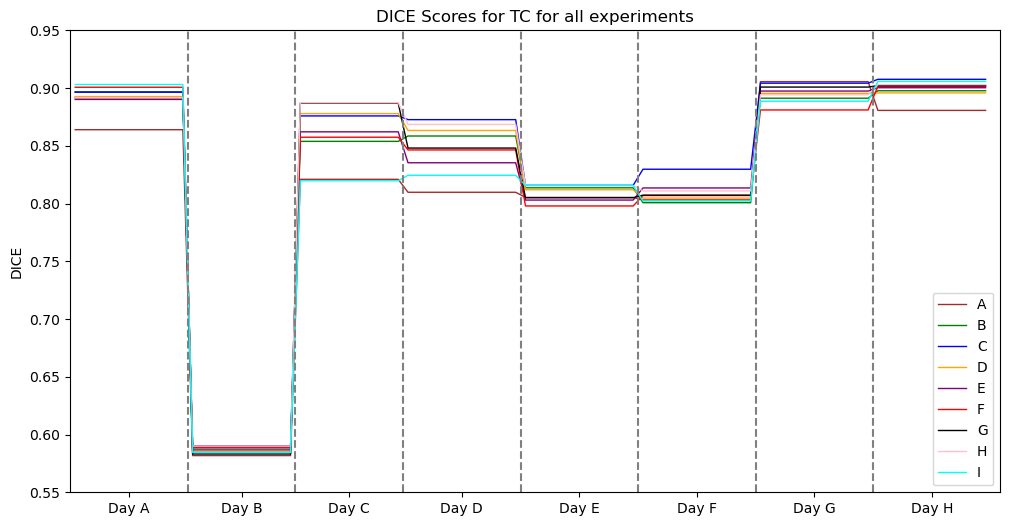

In [56]:
#Example usage 3D MesTruncus for validation subjects for all models

basepath_label = '/home/klinfys/Desktop/nnUNet_raw/Dataset724_MesTruncus3D/labelsVal'
basepath_pred = '/home/klinfys/Desktop/nnUNet_raw/Dataset724_MesTruncus3D/imagesVal_pred_3d_fullres'
models = ['', '_4batch', '_24frames', '_32frames', '_512pixels', '_combi','_PRes', '_resenc', '_finalGLP17' ]

days = [chr(day) for day in range(ord('A'), ord('H') + 1)]

vessel1 = 'SMA'
vessel2 = 'VP'

basepath_label2D = '/home/klinfys/Desktop/nnUNet_raw/Dataset723_MesTruncus2D/labelsVal'
basepath_pred2D = '/home/klinfys/Desktop/nnUNet_raw/Dataset723_MesTruncus2D/imagesVal_pred'

days = [chr(day) for day in range(ord('A'), ord('H') + 1)]

# m_2d = dice_results_for_2d(basepath_label2D, basepath_pred2D)

# results_dict = dice_results_for_all(basepath_label, basepath_pred, models)
# m_3d, m_4batch, m_24frames, m_32frames,m_512pixels, m_4batch_resenc, m_512pixels_resenc, m_resenc, m_1000epochs = [results_dict[f'model{model}'] for model in models] 
plot_ds_for_allMT(m_2d, m_3d, m_4batch, m_24frames, m_32frames, m_4batch_resenc, m_512pixels_resenc, m_resenc, m_1000epochs, days)

##### For one model #####
#results = dice_results_for_training(basepath_label, basepath_pred)
# plot_ds_for_training(results, days, experiment='F', vessel1, vessel2)


Unique Subjects: ['01' '02']


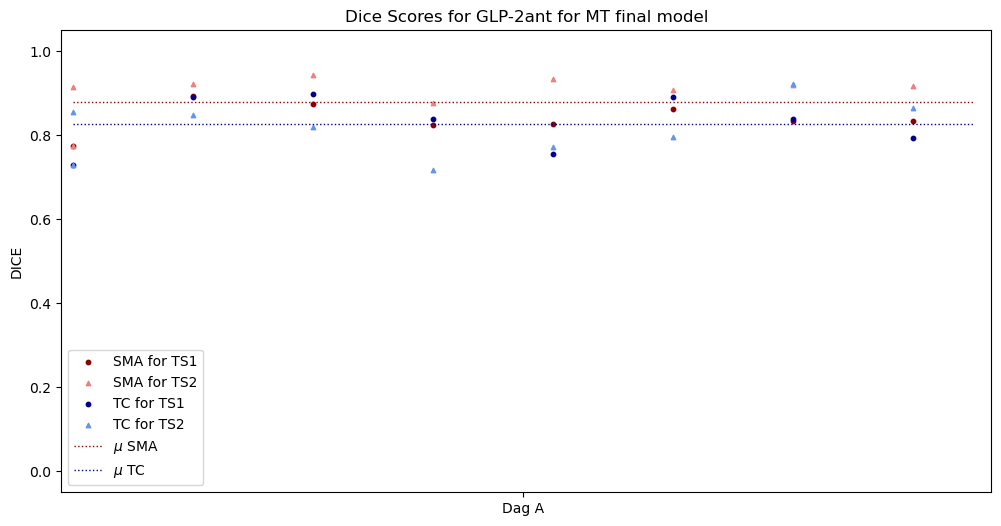

In [155]:
#Example usage 3D MesTruncus for testsubject in GA-17b

basepath_label = '/home/klinfys/Desktop/nnUNet_raw/Dataset365_GLP2antMT/labelsTs'
basepath_pred = '/home/klinfys/Desktop/nnUNet_raw/Dataset365_GLP2antMT/imagesTs_pred_3d_fullres'

vessel1 = 'SMA'
vessel2 = 'TC'
experiment = ''

days = [chr(day) for day in range(ord('A'), ord('A') + 1)]

#results = dice_results_for_training_GLP2ant(basepath_label, basepath_pred)
plot_ds_for_training(results, days, experiment, vessel1, vessel2)

Unique Subjects: ['DM']


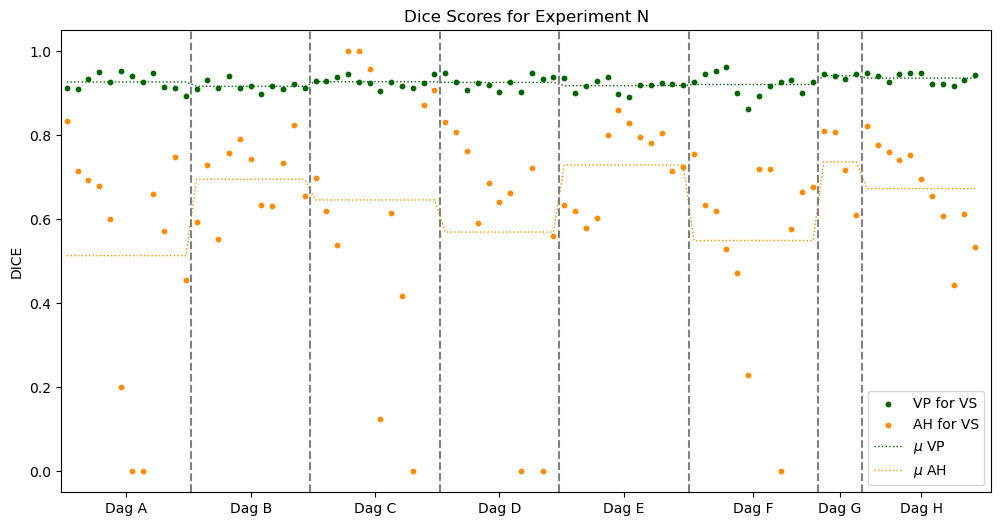

In [50]:
#Example usage 3D VenaHepa for validation subjects for all models

basepath_label = '/home/klinfys/Desktop/nnUNet_raw/Dataset502_VenaHepa3D/labelsVal'
basepath_pred = '/home/klinfys/Desktop/nnUNet_raw/Dataset502_VenaHepa3D/imagesVal_pred_3d_fullres_resenc'
#models = ['', '_4batch', '_512pixels', '_resenc']
experiment = 'N'
vessel1 = 'VP'
vessel2 = 'AH'

days = [chr(day) for day in range(ord('A'), ord('H') + 1)]

basepath_label2D = '/home/klinfys/Desktop/nnUNet_raw/Dataset502_VenaHeps2D/labelsVal'
basepath_pred2D = '/home/klinfys/Desktop/nnUNet_raw/Dataset502_VenaHeps2D/imagesVal_pred'



##### For one model #####
#results = dice_results_for_training(basepath_label, basepath_pred)
#plot_ds_for_training(results, days, experiment, vessel1, vessel2)


#### For all models #####
m_2d = dice_results_for_2d(basepath_label2D, basepath_pred2D)

results_dict = dice_results_for_all(basepath_label, basepath_pred, models)
m_3d, m_4batch,m_512pixels, m_resenc = [results_dict[f'model{model}'] for model in models] 
plot_ds_for_allVH(m_3d, m_4batch,m_512pixels, m_resenc, days)




Unique Subjects: ['JN' 'HL']


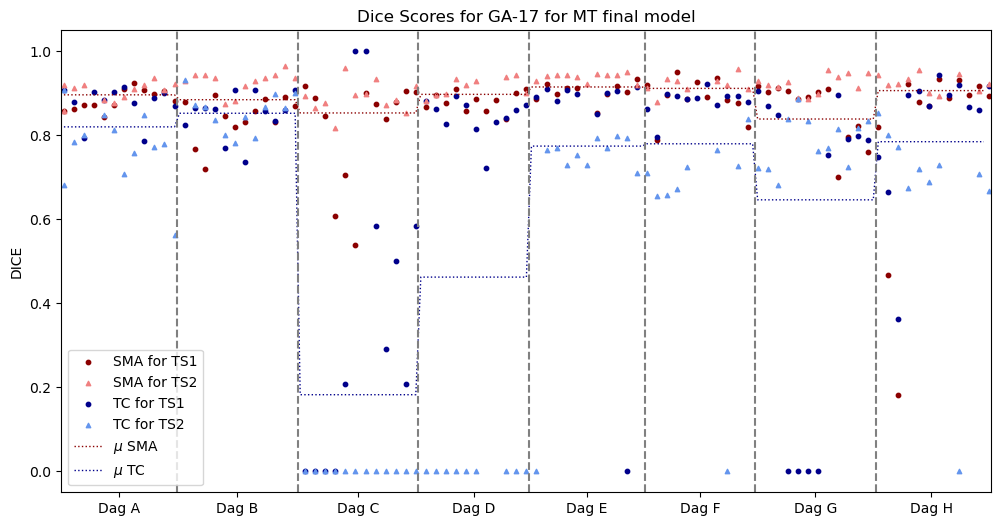

In [140]:
#Example usage 3D MesTruncus for test subject

basepath_label = '/home/klinfys/Desktop/nnUNet_raw/Dataset724_MesTruncus3D/labelsTs'
basepath_pred = '/home/klinfys/Desktop/nnUNet_raw/Dataset724_MesTruncus3D/imagesTs_pred_3d_fullres'

experiment = ''
vessel1 = 'SMA'
vessel2 = 'TC'

days = [chr(day) for day in range(ord('A'), ord('H') + 1)]

#results = dice_results_for_training(basepath_label, basepath_pred)
plot_ds_for_training(results, days, experiment, vessel1, vessel2)




Day A has 23 MRs
Day B has 24 MRs
Day C has 24 MRs
Day D has 24 MRs
Day E has 23 MRs
Day F has 23 MRs
Day G has 24 MRs
Day H has 24 MRs
Unique Subjects: ['JN' 'HL']


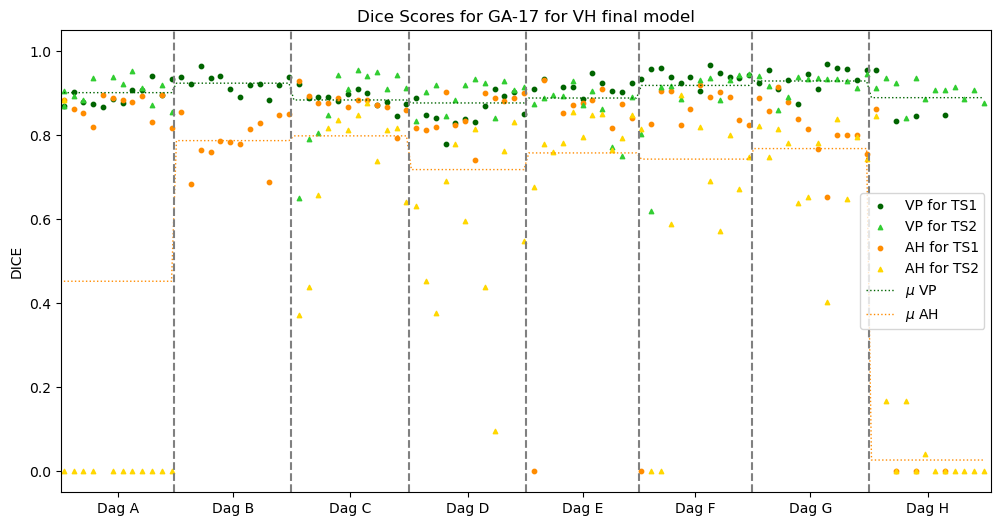

In [134]:
#Example usage 3D VenaHepa for testsubject

basepath_label = '/home/klinfys/Desktop/nnUNet_raw/Dataset502_VenaHepa3D/labelsTs'
basepath_pred = '/home/klinfys/Desktop/nnUNet_raw/Dataset502_VenaHepa3D/imagesTs_pred_3d_fullres_final'


days = [chr(day) for day in range(ord('A'), ord('H') + 1)]

#results = dice_results_for_training(basepath_label, basepath_pred)
plot_ds_for_training(results, days, experiment='', vessel1='VP', vessel2='AH')

